# Plane Wave Fitting for Slowness Estimation
December,2021


plane wave fitting by iterating over all possible values of phi

In [3]:
# importing the requiered libraries

import numpy as np
import matplotlib.pyplot as plt
from sympy import *
import random


##### initialize no. of receivers, apparent horizontal velocity of sound, max frequency of source 

In [4]:

n_grp=10 # no. of receivers in a subset and not the number of subset
no_of_subsets=2
n_rec=n_grp*no_of_subsets #  ;number of receivers, to be kept odd for first run

rec_pos_act= np.zeros(shape =(n_rec,2))  # Assigning thr actual receiver position

v = 200 # m/s ### velocity of propagation (in sand)
freq=2 #Hz, max recorded frequency
lamda=v/freq# wavelength
d=2000#m,  l=2000m  > 10 times lamda 

##### initialize position of source and  receivers 

In [5]:
#setting source configuration randomly
np.random.seed(0)
a=random.randint(int(d-d/10),d*5) # sourec distance must be more than or equal to d , limits set here are arbitary within this acceptance
b=random.randint(int(d-d/10),d*5)
src=(b,a)
random.randrange(d-d/10,d*5)


#setting different receiver configurations

#uncomment following line for random distribution
rec_pos_act=np.random.normal(0,100,size=(n_rec,2))


#uncomment following line for linear distribution
for i in range(0,n_rec):
    rec_pos_act[i,1]=0
    rec_pos_act[i,0]=(i-(n_rec-1)/2)*5 #first receievr at (-50,0) last at (50,0), all in line, distance 5 between them 

#uncomment following line for circular distribution    
for i in range(0,int(n_rec/2)):
    rec_pos_act[i,0]=100*cos((2*i)*2*np.pi/n_rec)
    rec_pos_act[int(i+n_rec/2),0]=100*cos((2*i+1)*2*np.pi/n_rec)
    rec_pos_act[i,1]=100*sin((2*i)*2*np.pi/n_rec)
    rec_pos_act[int(i+n_rec/2),1]=100*sin((2*i+1)*2*np.pi/n_rec)




initialize time recordings by time of arrival, introduce noise in time and position

In [6]:


t_rec_ideal = np.zeros(shape =(n_rec,))  # time recorded in each receiver; form: (index of receiver,time) 


t_noise=np.random.normal(0,5/(v),size=(n_rec,))

#introduce noise in position
rec_pos_noise=np.random.normal(0,1,size=(n_rec,2))

rec_pos_mes= rec_pos_act #+ rec_pos_noise  # rec_pos_mes stores[(x1,y1),(x2,y2),..] 



#initialising time recordings

for i in range (0,n_rec):
    t_rec_ideal[0:n_rec] = np.sqrt((rec_pos_mes[0:n_rec,0]-src[0])**2 + (rec_pos_mes[0:n_rec,1]-src[1])**2)/v



### t_Rec_real has form [[rec1 recording], [rec2 recording]]

# introduce noise in time
t_Rec_real=t_rec_ideal #+ t_noise


# time difference between time recordings wrt receiver 1st rec, 
#in the form : time recorded by receiver at ith position - time recorded by 1st receiver 
t_diff=np.zeros(shape=(n_rec,))
for i in range(0,n_rec):
    t_diff[i]=t_rec_ideal[i]-t_rec_ideal[0]
    
   
    
    
    

We iterate over all values of the backazimuth $\phi$ such that it minimizes the error expression for 
N receivers:
$\hat{s} = \min_{s}\sum_{i=1}^{N} (\tau_{i} - r_{i}.s)^2 $
where i is the index of the receivers
$\tau_{i}$ is the time difference for $i^{th}$ receiver
where the slowness vector $\vec{s}$ is defined as:
$\vec{s} = (-\frac{\sin{\phi}}{v}, -\frac{\cos{\phi}}{v})$

In [7]:
#function to return the error expression for a particular s, v and given configuration of receivers : 

def sum_of_errors(s_x,s_y,n_rec,rec_loc,time_diff):
    ''' returns the error expression for particular  slowness vector s , apparent horizontal velocity v, receiver positions, and time differences\
        input s in form of s_x and s_y ( x and y coordinate ) \
        input n_rec: number of receivers \
        input rec_loc: 2-D array for receiver location , in form [(x_1,y_1),...(x_n_rec,y_n_rec)]\
        input time_diff: 1-D array for time difference [(t_i)]'''  
    soe=0 # sume of errors
    # find sum over all receivers
    for i in range (0,n_rec):
        soe+=(time_diff[i]-s_x*rec_loc[i,0]-s_y*rec_loc[i,1])**2
    return soe    

In [8]:
#function to estimate slowness by iterating over backazimuth

def estimate_slowness(v,n_rec,rec_loc,time_diff):
    ''' returns estimated backazimuth and final error for the estimated backazimuth\
    input v: apparent horizontal velocity\
    inputn_rec: number of receivers\
    input rec_loc: 2-D array for receiver locations in form [(x_1,y_2)]\
    input time_diff: 1-D array for time difference [(t_i)]'''
    phi_estimated=0
    error=10000
    phi_range = np.linspace(0,2*np.pi,200000)
    for phi in phi_range :
            soe=sum_of_errors(-np.sin(phi)/v,-np.cos(phi)/v,n_rec,rec_loc,time_diff)  
            #print(s_x_temp,s_y_temp)
            #print(soe)
            #print(s_x_temp,s_y_temp
            if ( error>soe):
                error =soe
                phi_estimated=phi
    if (sum_of_errors(-np.sin(np.pi-phi_estimated)/v,-np.cos(np.pi-phi_estimated)/v,n_rec,rec_loc,time_diff)<error) :
        error=sum_of_errors(-np.sin(np.pi-phi_estimated)/v,-np.cos(np.pi-phi_estimated)/v,n_rec,rec_loc,time_diff)
        phi_estimated=np.pi-phi_estimated
    return (phi_estimated,error)  

In [9]:

phi_actual=np.arctan2(src[0],src[1]) #y first for arctan2,rotate axis (N is x now), so input x first
if (phi_actual<0):
    phi_actual+=2*np.pi
              
print("actual angle: ", phi_actual)
phi_estimated,final_error=estimate_slowness(v,n_rec,rec_pos_mes,t_diff)
print("phi_estimated :",phi_estimated,"\nfinal_error: ", final_error)

print("pi- phi_estimated :",np.pi-phi_estimated)
print(" difference in backazimuth (diff of pi): ",np.pi-phi_estimated-phi_actual," percentage error : ",((np.pi-phi_estimated)/phi_actual-1)*100,"%"  )

print("difference in backazimuth: ",phi_estimated-phi_actual,"\npercentage error in backazimuth: ",((phi_estimated)/phi_actual-1)*100,"%"  )
print("diff in location: " ,  np.sqrt((src[0]-d*np.sin(phi_estimated))**2+(src[1]-d*np.cos(phi_estimated))**2))
print("diff in location (diff of pi): " ,  np.sqrt((src[0]-d*np.sin(np.pi-phi_estimated))**2+(src[1]-d*np.cos(np.pi-phi_estimated))**2))
print("percentage error in distance: ",(np.sqrt((src[0]-d*np.sin(phi_estimated))**2+\
                                               (src[1]-d*np.cos(phi_estimated))**2)/ np.sqrt(src[0]**2+src[1]**2) )*100,"%")
src_estimated=d*np.sin(phi_estimated),d*np.cos(phi_estimated)
print(src_estimated)
print(src)

actual angle:  1.0288541108911162
phi_estimated : 1.028845322350733 
final_error:  3.6901125892728808
pi- phi_estimated : 2.11274733123906
 difference in backazimuth (diff of pi):  1.0838932203479437  percentage error :  105.34955431233652 %
difference in backazimuth:  -8.788540383219967e-06 
percentage error in backazimuth:  -0.0008542066645023105 %
diff in location:  2842.9541605588656
diff in location (diff of pi):  4288.391718955124
percentage error in distance:  58.70289220965977 %
(1713.4079359941043, 1031.616811065244)
(4149, 2498)


In [10]:
print(np.pi-phi_estimated)

2.11274733123906


In [11]:
sum_of_errors(-np.sin(phi_actual)/v,-np.cos(phi_actual)/v,n_rec,rec_pos_mes,t_diff)

3.690112589079794

In [12]:
#sum_of_errors(-np.sin(np.pi-phi_estimated)/v,-np.cos(np.pi-phi_actual)/v,n_rec,rec_pos_mes,t_diff)

In [13]:
x=np.linspace(0,2*np.pi,2000)
y=np.zeros(shape=(2000,))
for i in range(0,2000):
    y[i]=sum_of_errors(-sin(x[i])/v,-cos(x[i])/v,n_rec,rec_pos_mes,t_diff)

Text(0, 0.5, 'error in arbitary units')

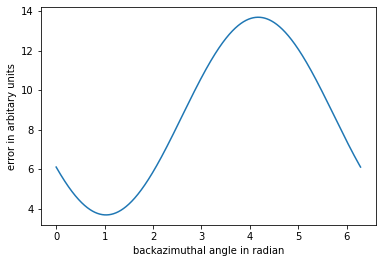

In [14]:
plt.plot(x,y)
plt.xlabel("backazimuthal angle in radian")
plt.ylabel("error in arbitary units")


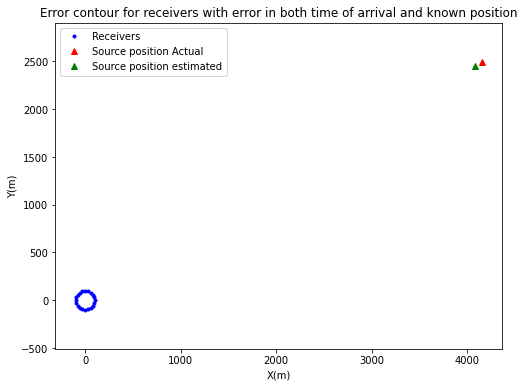

In [16]:
x,y =np.mgrid[-500:500:1000j,-500:500:1000j]  # a 2D grid for defining domain and evaluation of source position

rec_pos_modified = np.zeros_like(rec_pos_act)
rec_pos_modified[:] = rec_pos_act[:]  # Can modify later if required

plt.figure(figsize=(8,6))
plt.plot(rec_pos_mes[:,0],rec_pos_mes[:,1],'b.',label='Receivers')
plt.plot(src[0],src[1],'r^',label='Source position Actual')
d=v*t_Rec_real[0]
plt.plot(d*np.sin(phi_estimated),d*np.cos(phi_estimated),'g^',label='Source position estimated')

#plt.plot(d*np.sin(np.pi-phi_estimated),d*np.cos(np.pi-phi_estimated),'g^',label='Source position estimated')
#plt.plot(d*np.sin(np.pi/2-phi_estimated),d*np.cos(np.pi/2-phi_estimated),'g^',label='Source position estimated')
plt.plot()
plt.legend()
#plt.xlim(-500,500)
#plt.ylim(-500,500)
plt.xlabel('X(m)')
plt.ylabel('Y(m)')
plt.axis('equal')

plt.title('Error contour for receivers with error in both time of arrival and known position')
plt.show()

     

Cause of the error is because the estimated position assumes that first receiver (at index 0) is at origin ,\\
whereas this is not the case for circular configuration

Configurations tried so far:
linear,
gaussian(negative results),
circular

Noise introduced in position has standard deviation 5m; and that in time has standard deviation 5/v

In [33]:
def error_in_concurrency(v,n_rec,no_of_groups,n_in_this_grp,rec_loc,time,time_diff):
    estimates_of_src=np.zeros(shape=(no_of_groups,2))
    #iteration for group
    for i in range(0,n_rec,n_in_this_grp):
        #print(i,i+n_in_this_grp)
        new_rec_loc=np.zeros(shape=(n_in_this_grp,2))
        for k in range(0,n_in_this_grp):
            new_rec_loc[k][0]=rec_loc[k+i][0]-rec_loc[i][0]
            new_rec_loc[k][1]=rec_loc[k+i][1]-rec_loc[i][1]
        phi,error=estimate_slowness(v,n_in_this_grp,new_rec_loc,time_diff[i:i+n_in_this_grp])
      
        d_i=v*time[i]
        #print(d_i)
        #print(new_rec_loc)
        #print("phi: ", phi)
        #print("d_i*np.sin(phi): ",d_i*np.sin(phi),"d_i*np.cos(phi): ",d_i*np.cos(phi))
        #print("rec_loc[i][0]+d_i*np.sin(phi): ",rec_loc[i][0]+d_i*np.sin(phi),"rec_loc[i][1]+d_i*np.cos(phi): ",rec_loc[i][1]+d_i*np.cos(phi))
        estimates_of_src[int(i/n_in_this_grp)]=(rec_loc[i][0]+d_i*np.sin(phi),rec_loc[i][1]+d_i*np.cos(phi))
        error_in_conc=0
        
    for j in range(0,no_of_groups):   
            error_in_conc+=np.sqrt((estimates_of_src[int(j)%int(no_of_groups)][0]-estimates_of_src[int(j+1)%int(no_of_groups)][0])**2\
    
                                + (estimates_of_src[int(j)%int(no_of_groups)][1]-estimates_of_src[int(j+1)%int(no_of_groups)][1])**2)
            

    return error_in_conc ,estimates_of_src      
    

In [34]:
distance_error,estimates=error_in_concurrency(v,n_rec,no_of_subsets,n_grp,rec_pos_mes,t_Rec_real,t_diff)


In [40]:
def find_velocity(guessed_vel,n_rec,no_of_groups,n_in_this_grp,rec_loc,time,time_diff):
    err=10000
    velocity=0
    v_range=np.linspace(guessed_vel*0.9,guessed_vel*1.1,20)
    for v in v_range:
        err_iter,estimates=error_in_concurrency(v,n_rec,no_of_groups,n_in_this_grp,rec_loc,time,time_diff)
        print(err_iter)
        if(err>err_iter):
            err=err_iter
            velocity=v
    return velocity        

In [41]:
v=find_velocity(193,n_rec,no_of_subsets,n_grp,rec_pos_mes,t_Rec_real,t_diff)
print(v)

642.2309489373906
629.6933668262276
619.0756728893416
610.1925807354237
602.8456940663062
597.3730616284249
593.2949601123312
591.2254125683969
590.6724245413316
591.6908655108889
594.3347643753345
598.3676363668241
603.5391948033598
610.4831831260426
618.3506313648735
627.7774682248802
637.8866167732251
649.3185392587001
661.4814513840928
675.0278931454969
189.95263157894738


In [42]:
print(estimates,distance_error)

[[4124.80168811 2446.4160954 ]
 [3961.33698364 2700.12032946]] 603.6109607492069


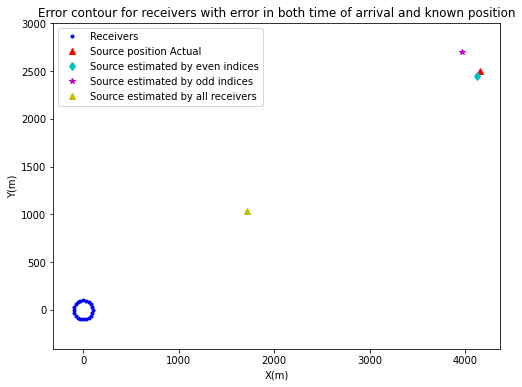

In [43]:
 x,y =np.mgrid[-500:500:1000j,-500:500:1000j]  # a 2D grid for defining domain and evaluation of source position



plt.figure(figsize=(8,6))
plt.plot(rec_pos_mes[:,0],rec_pos_mes[:,1],'b.',label='Receivers')
plt.plot(src[0],src[1],'r^',label='Source position Actual')
d=v*t_Rec_real[n_grp]
plt.plot(estimates[0][0],estimates[0][1],'cd',label='Source estimated by even indices')
plt.plot(estimates[1][0],estimates[1][1],'m*',label='Source estimated by odd indices')
plt.plot(src_estimated[0],src_estimated[1],'y^',label='Source estimated by all receivers')
#plt.plot(d*np.sin(np.pi-phi_estimated),d*np.cos(np.pi-phi_estimated),'g^',label='Source position estimated')
#plt.plot(d*np.sin(np.pi/2-phi_estimated),d*np.cos(np.pi/2-phi_estimated),'g^',label='Source position estimated')
plt.plot()
plt.legend()
#plt.xlim(-500,500)
#plt.ylim(-500,500)
plt.xlabel('X(m)')
plt.ylabel('Y(m)')
plt.axis('equal')

plt.title('Error contour for receivers with error in both time of arrival and known position')
plt.show()

     

In [25]:
sum_of_errors(-np.sin(phi)/v,-np.cos(phi)/v,n_grp,new_rec_loc,t_diff[n_grp:2*n_grp])  

0.05018147357211877

In [26]:
 sum_of_errors(-np.sin(2*np.pi-phi)/v,-np.cos(2*np.pi-phi)/v,n_grp,new_rec_loc,t_diff[n_grp:2*n_grp])  

5.825676787396036